In [3]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms


In [4]:
def load_images(folder_path, label, img_size=(224, 224)):
    data, labels = [], []
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        img = Image.open(filepath).convert("RGB")
        img = transform(img)
        data.append(img)
        labels.append(label)
    
    return data, labels

# Load panda and rat images
panda_data, panda_labels = load_images("/kaggle/input/panda-vs-rat/images/panda", label=0)
rat_data, rat_labels = load_images("/kaggle/input/panda-vs-rat/images/rat", label=1)

# Combine datasets
data = panda_data + rat_data
labels = panda_labels + rat_labels

# Convert to tensors
data = torch.stack(data)
labels = torch.tensor(labels)


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)


In [20]:
class MLP_VGG16(nn.Module):
    def __init__(self, input_size=224*224*3, num_classes=2):
        super(MLP_VGG16, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 1024),  # Fully connected layer 1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),         # Fully connected layer 2
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),          # Fully connected layer 3
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)   # Output layer
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP_VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data to device
train_data, train_labels = train_data.to(device), train_labels.to(device)
test_data, test_labels = test_data.to(device), test_labels.to(device)

In [22]:
import time
import pandas as pd

# Define the metrics dictionary
metrics = {
    "Model": [],
    "Training Time (s)": [],
    "Training Loss": [],
    "Training Accuracy": [],
    "Testing Accuracy": [],
    "Number of Parameters": []
}

# Training loop with metrics collection
num_epochs = 200
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    with torch.no_grad():
        _, train_predicted = torch.max(outputs, 1)
        train_accuracy = (train_predicted == train_labels).float().mean()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = (test_predicted == test_labels).float().mean()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Accuracy: {train_accuracy.item():.4f}, Test Accuracy: {test_accuracy.item():.4f}")

end_time = time.time()
training_time = end_time - start_time

# Calculate number of model parameters
num_params = sum(p.numel() for p in model.parameters())

# Save metrics
metrics["Model"].append("MLP_VGG16")
metrics["Training Time (s)"].append(training_time)
metrics["Training Loss"].append(loss.item())
metrics["Training Accuracy"].append(train_accuracy.item())
metrics["Testing Accuracy"].append(test_accuracy.item())
metrics["Number of Parameters"].append(num_params)

# Convert metrics to a DataFrame and display as a table
df_metrics = pd.DataFrame(metrics)
print("\nModel Performance Summary:")
display(df_metrics)


Epoch 1/200, Loss: 0.7019, Train Accuracy: 0.4062, Test Accuracy: 0.5000
Epoch 2/200, Loss: 14.0366, Train Accuracy: 0.4875, Test Accuracy: 0.5000
Epoch 3/200, Loss: 54.5639, Train Accuracy: 0.5000, Test Accuracy: 0.5000
Epoch 4/200, Loss: 17.0212, Train Accuracy: 0.5125, Test Accuracy: 0.5000
Epoch 5/200, Loss: 5.3840, Train Accuracy: 0.5250, Test Accuracy: 0.5000
Epoch 6/200, Loss: 7.6015, Train Accuracy: 0.5063, Test Accuracy: 0.5000
Epoch 7/200, Loss: 4.0184, Train Accuracy: 0.5437, Test Accuracy: 0.5000
Epoch 8/200, Loss: 3.7584, Train Accuracy: 0.5250, Test Accuracy: 0.5000
Epoch 9/200, Loss: 4.3598, Train Accuracy: 0.5375, Test Accuracy: 0.5000
Epoch 10/200, Loss: 3.4066, Train Accuracy: 0.5375, Test Accuracy: 0.5000
Epoch 11/200, Loss: 2.5729, Train Accuracy: 0.5688, Test Accuracy: 0.5000
Epoch 12/200, Loss: 3.3998, Train Accuracy: 0.4688, Test Accuracy: 0.5000
Epoch 13/200, Loss: 3.4844, Train Accuracy: 0.4625, Test Accuracy: 0.5000
Epoch 14/200, Loss: 2.8950, Train Accuracy: 

,Model,Training Time (s),Training Loss,Training Accuracy,Testing Accuracy,Number of Parameters
0,MLP_VGG16,10.745471,0.038982,0.9875,0.875,154798338


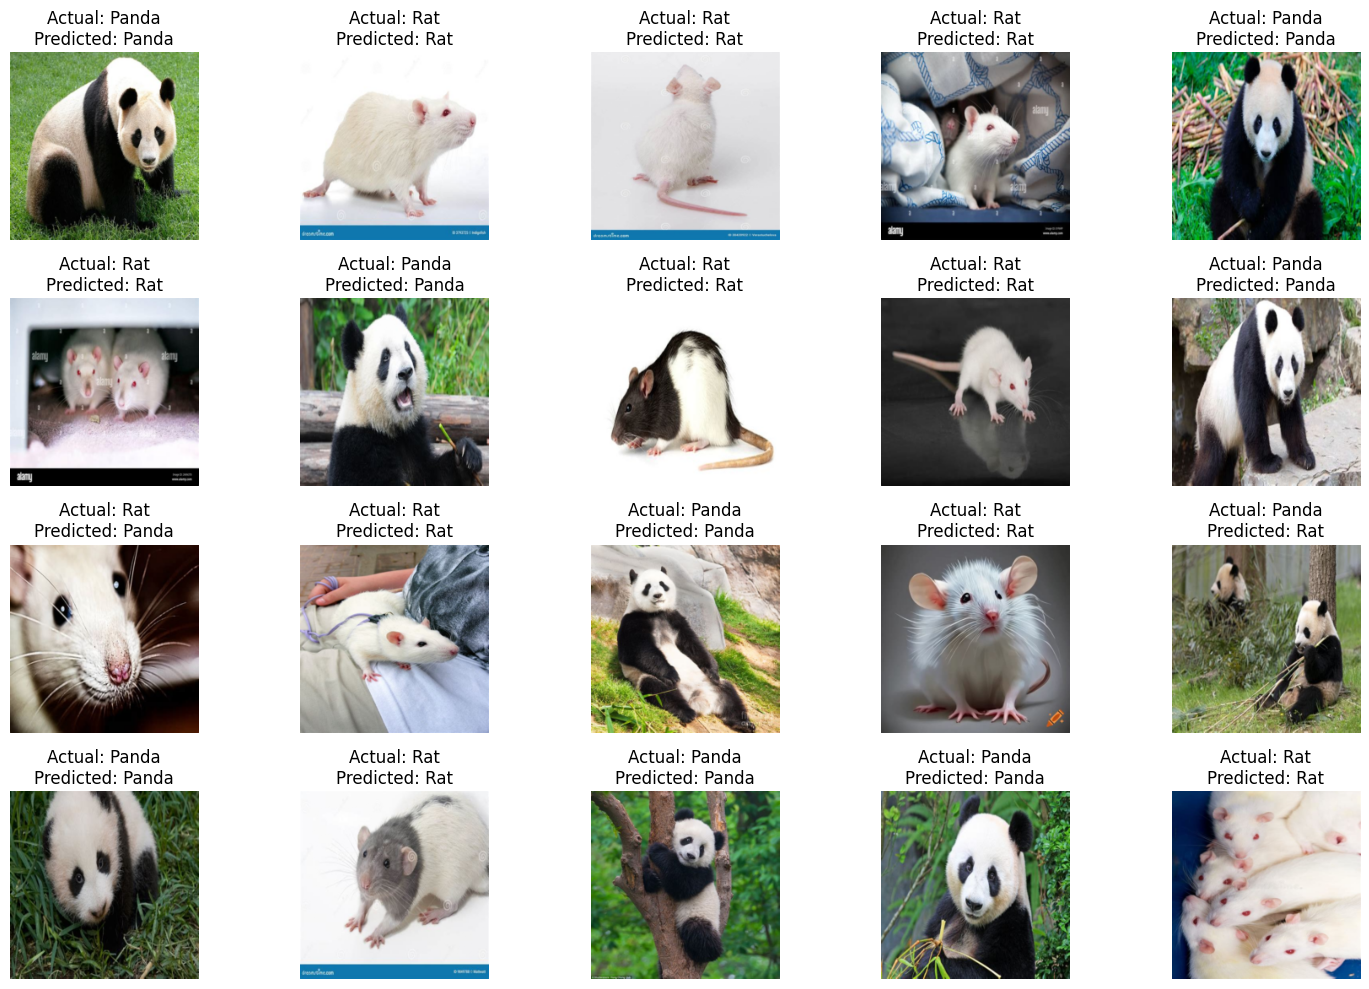

In [23]:
import matplotlib.pyplot as plt

# Function to plot test images with actual and predicted labels
def plot_test_results(test_data, test_labels, predicted_labels, class_names, num_images=20):
    num_images = min(len(test_data), num_images)
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(4, 5, i + 1)
        image = test_data[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(image)
        actual_label = class_names[test_labels[i].item()]
        predicted_label = class_names[predicted_labels[i].item()]
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Evaluate model on test data and get predictions
model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
    _, predicted_labels = torch.max(test_outputs, 1)

# Plot results
class_names = ["Panda", "Rat"]
plot_test_results(test_data, test_labels, predicted_labels, class_names)


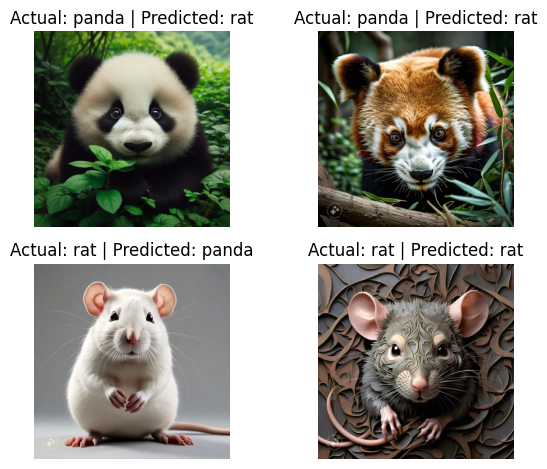

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Image paths
image_paths = ['/kaggle/input/ai-generated-panda-v-rat/AI_gen_images/p_e.jpeg', '/kaggle/input/ai-generated-panda-v-rat/AI_gen_images/p_h.jpeg', '/kaggle/input/ai-generated-panda-v-rat/AI_gen_images/r_e.jpeg', '/kaggle/input/ai-generated-panda-v-rat/AI_gen_images/r_h.jpeg']
labels = ['panda', 'panda', 'rat', 'rat']  # Actual labels

# Prepare a list for the predictions
predictions = []

# Iterate through each image, make predictions, and plot
for i, image_path in enumerate(image_paths):
    # Load and transform the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to the correct device

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = torch.max(output, 1)  # Get the predicted label
        predicted_label = 'panda' if predicted_label.item() == 0 else 'rat'
    
    predictions.append(predicted_label)

    # Plot the image along with actual and predicted labels
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.title(f"Actual: {labels[i]} | Predicted: {predicted_label}")
    plt.axis('off')

# Show the plot with all the images
plt.tight_layout()
plt.show()